In [1]:
import numpy as np
import torch

import asyncio
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
%gui asyncio

In [2]:
max_rejected = 0.9

# save_path = None
# save_path = "/beegfs/home/r.kail/faces/figures/merged/mul_vs_harmonic.png"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/04_sigm_coef_selection.pdf"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/04_sigm_coef_selection_small.pdf"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/03_new_distances.pdf"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/06_relu.pdf"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/06_relu_small.pdf"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/07_MLP.pdf"
# save_path = "/beegfs/home/r.kail/faces/figures/merged/08_emb_norm_vs_others.pdf"
save_path = "/beegfs/home/r.kail/faces/figures/merged/09_90%_rejected.pdf"

# save_path = "/home/romakail/Downloads/test.jpg"

# table_paths = {
#     "PFE": "/beegfs/home/r.kail/faces/figures/03_classic_PFE/until_0.5/table.pt",
#     "exp": "/beegfs/home/r.kail/faces/figures/08_scale_frozen/exp/table.pt",
#     "sigm_mul": "/beegfs/home/r.kail/faces/figures/08_scale_frozen/sigm_mul/table.pt",
#     "sigm_sum_mul": "/beegfs/home/r.kail/faces/figures/08_scale_frozen/sigm_sum_mul/table.pt",
# }

# ## sigm_mul_coef
# table_paths = {
#     "PFE": "/beegfs/home/r.kail/faces/figures/03_classic_PFE/until_0.5/table.pt",
# #     "8": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/8/table.pt",
# #     "16": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/16/table.pt",
#     "32": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/32/table.pt",
#     "48": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/48/table.pt",
# #     "56": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/56/table.pt",
# #     "64": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/64/table.pt",
# #     "72": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/72/table.pt",
# #     "80": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/80/table.pt",
#     "128": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/128/table.pt",
# }

# ## New distance measures
# table_paths = {
#     "PFE": "/beegfs/home/r.kail/faces/figures/03_classic_PFE/until_0.5/table.pt",
#     "48*sigm": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/48/table.pt",
# }

## relu
# table_paths = {
#     "PFE": "/beegfs/home/r.kail/faces/figures/03_classic_PFE/until_0.5/table.pt",
#     "48*sigm": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/48/table.pt",
#     "1*relu": "/beegfs/home/r.kail/faces/figures/13_relu/1/table.pt",
#     "8*relu": "/beegfs/home/r.kail/faces/figures/13_relu/8/table.pt",
# }

## MLP
# table_paths = {
#     "PFE": "/beegfs/home/r.kail/faces/figures/03_classic_PFE/until_0.5/table.pt",
#     "1": "/beegfs/home/r.kail/faces/figures/12_MLP_layers/1/table.pt",
#     "2": "/beegfs/home/r.kail/faces/figures/12_MLP_layers/2/table.pt",
#     "3": "/beegfs/home/r.kail/faces/figures/12_MLP_layers/3/table.pt",
#     "4": "/beegfs/home/r.kail/faces/figures/12_MLP_layers/4/table.pt",
# }


# # Embedding norm vs others
# table_paths = {
#     "PFE": "/beegfs/home/r.kail/faces/figures/03_classic_PFE/until_0.5/table.pt",
#     "48*sigm": "/beegfs/home/r.kail/faces/figures/09_scale_sigm_mul_coef/48/table.pt",
#     "emb_norm": "/beegfs/home/r.kail/faces/figures/15_emb_norm_uncertainty/table.pt"
# }

# # 90% rejected
table_paths = {
    "norm": "/beegfs/home/r.kail/faces/figures/16_90%_rejected/norm/table.pt",
    "pfe": "/beegfs/home/r.kail/faces/figures/16_90%_rejected/pfe/table.pt",
    "scale": "/beegfs/home/r.kail/faces/figures/16_90%_rejected/scale/table.pt",
}


In [3]:
def wait_for_change(widget, value):
    future = asyncio.Future()
    def getvalue(change):
        # make the new value available
        future.set_result(change.new)
        widget.unobserve(getvalue, value)
    widget.observe(getvalue, value)
    return future

def get_tables(table_paths):
    tables = {}
    for name, path in table_paths.items():
        tables[name] = torch.load(path, map_location=torch.device("cpu"))
    return tables

def wait_for_button_click():
    # TODO
    # finish_button =  widgets.Button(
    #     description="Finish",
    #     disabled=False,
    #     button_style='', # 'success', 'info', 'warning', 'danger' or ''
    #     icon='check' # (FontAwesome names without the `fa-` prefix)
    # )
    # display(finish_button)
    #
    # waited_value = await wait_for_change(finish_button, "some val")
    pass

def get_figures_parameters(tables):

    selectors = []
    for name, table in tables.items():
        options = [(" ".join(key), key) for key in table.keys()]
        print(name)
        selector = widgets.SelectMultiple(
            options=options,
            description="Choose methods\nUse Ctrl for multiple",
            disabled=False,
            button_style="success",
        )
        display(selector)
        selectors.append(selector)

    wait_for_button_click()

    return selectors

def get_FAR_selector(tables):
    possible_FARs = set(list(tables.values())[0][list(list(tables.values())[0].keys())[0]].keys()) # this is the crutchest crutch ever
    for table in tables.values():
        for results in table.values():
            cur_FARs = list(results.keys())
            possible_FARs &= set(cur_FARs)

    print("Choose FARs")
    possible_FARs = list(sorted(possible_FARs))
    FAR_selector = widgets.SelectMultiple(
        options=possible_FARs,
        description="Choose FAR",
        disabled=False,
        button_style="success",
    )
    display(FAR_selector)
    return FAR_selector


def get_selectors_values(selectors, FAR_selector):
    FARs = FAR_selector.get_interact_value()

    selected_vals = []
    for selector in selectors:
        selected_vals.append(selector.get_interact_value())

    return selected_vals, FARs

In [4]:
tables = get_tables(table_paths)
selectors = get_figures_parameters(tables)
FAR_selector = get_FAR_selector(tables)

norm


SelectMultiple(description='Choose methods\nUse Ctrl for multiple', options=(('cosine mean', ('cosine', 'mean'…

pfe


SelectMultiple(description='Choose methods\nUse Ctrl for multiple', options=(('cosine mean', ('cosine', 'mean'…

scale


SelectMultiple(description='Choose methods\nUse Ctrl for multiple', options=(('cosine mean', ('cosine', 'mean'…

Choose FARs


SelectMultiple(description='Choose FAR', options=(0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05), value=())

In [5]:
methods, FARs = get_selectors_values(selectors, FAR_selector)
print(methods)
print(FARs)

[(('cosine', 'harmonic-harmonic'),), (('cosine', 'harmonic-sum'),), (('cosine', 'harmonic-harmonic'),)]
(0.0001, 0.001, 0.05)


In [6]:
def plot_figure(tables, methods, FARs, save_path=None, max_rejected=max_rejected):
    fig, axes = plt.subplots(nrows=1, ncols=len(FARs), figsize=(6 + 6 * len(FARs), 7))

    for far, ax in zip(FARs, axes):
        for method, (name, table) in zip(methods, tables.items()):
            for dist_unc in method:
                ax.plot(
                    np.linspace(0, max_rejected, len(table[dist_unc][far])),
                    table[dist_unc][far],
                    label=name + " " + " ".join(dist_unc),)
        ax.set_title(f"FAR={far}")
        ax.set_xlabel(f"rejected portion")
        ax.set_ylabel(f"TAR@FAR={far}")
        ax.legend()

    if save_path is not None:
        fig.savefig(save_path, dpi=400)

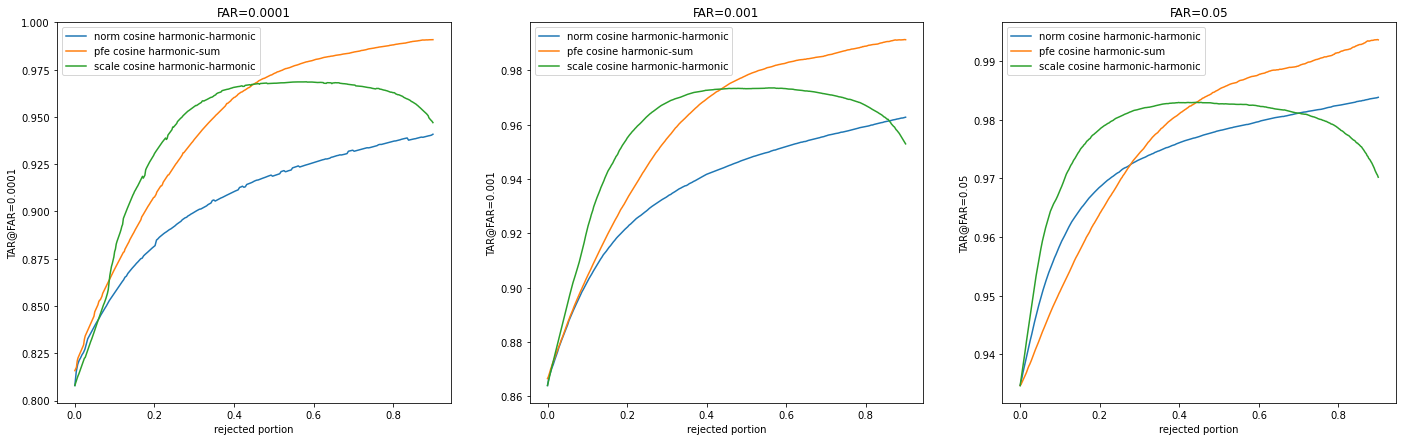

In [7]:
plot_figure(tables, methods, FARs, save_path=save_path)